# Dataset Preprocessing for News Classification
This notebook handles all data-related tasks including:
- Data loading and exploration
- Text preprocessing and cleaning
- Feature extraction (TF-IDF, word embeddings)
- Data visualization and analysis
- Saving processed data for model training

## 1. Import Required Libraries

In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Text processing
import re
import string
import nltk
from collections import Counter

# Machine learning and feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Dataset loading
from datasets import load_dataset

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully!")

/home/entropy/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Libraries imported successfully!


## 2. Download NLTK Data

In [2]:
# Download required NLTK data
import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk_downloads = ['stopwords', 'punkt', 'punkt_tab', 'wordnet', 'omw-1.4']

for item in nltk_downloads:
    try:
        nltk.download(item, quiet=True)
        print(f"✓ {item} downloaded")
    except Exception as e:
        print(f"✗ Failed to download {item}: {e}")

from nltk.corpus import stopwords
try:
    from nltk.tokenize import word_tokenize
    print("✓ NLTK tokenizer imported successfully")
except ImportError:
    print("✗ NLTK tokenizer import failed, using fallback")
    def word_tokenize(text):
        import re
        return re.findall(r'\b\w+\b', text.lower())

from nltk.stem import WordNetLemmatizer

✓ stopwords downloaded
✓ punkt downloaded
✓ punkt_tab downloaded
✓ wordnet downloaded
✓ omw-1.4 downloaded
✓ NLTK tokenizer imported successfully


## 3. Data Loading

In [3]:
def load_bbc_news_data():
    print("Loading BBC News dataset from Hugging Face...")
    dataset = load_dataset("SetFit/bbc-news")
    df = pd.DataFrame(dataset['train'])
    print(f"✓ Successfully loaded {len(df)} articles")
    return df

news_df = load_bbc_news_data()
print(f"Dataset shape: {news_df.shape}")
print(f"Columns: {list(news_df.columns)}")

Loading BBC News dataset from Hugging Face...
✓ Successfully loaded 1225 articles
Dataset shape: (1225, 3)
Columns: ['text', 'label', 'label_text']
✓ Successfully loaded 1225 articles
Dataset shape: (1225, 3)
Columns: ['text', 'label', 'label_text']


## 4. Exploratory Data Analysis (EDA)

In [4]:
print("=== DATASET OVERVIEW ===")
print(f"Total articles: {len(news_df)}")
print(f"Columns: {list(news_df.columns)}")
print(news_df.dtypes)
print(f"\n=== MISSING VALUES ===")
print(news_df.isnull().sum())
print(f"\n=== SAMPLE DATA ===")
display(news_df.head())

=== DATASET OVERVIEW ===
Total articles: 1225
Columns: ['text', 'label', 'label_text']
text          object
label          int64
label_text    object
dtype: object

=== MISSING VALUES ===
text          0
label         0
label_text    0
dtype: int64

=== SAMPLE DATA ===


,text,label,label_text
0,wales want rugby league training wales could f...,2,sport
1,china aviation seeks rescue deal scandal-hit j...,1,business
2,rock band u2 break ticket record u2 have smash...,3,entertainment
3,markets signal brazilian recovery the brazilia...,1,business
4,tough rules for ringtone sellers firms that fl...,0,tech


=== TEXT LENGTH STATISTICS ===
Average text length: 2289 characters
Average word count: 395 words
count     1225.000000
mean      2288.946122
std       1508.459075
min        501.000000
25%       1444.000000
50%       1976.000000
75%       2810.000000
max      25483.000000
Name: text_length, dtype: float64


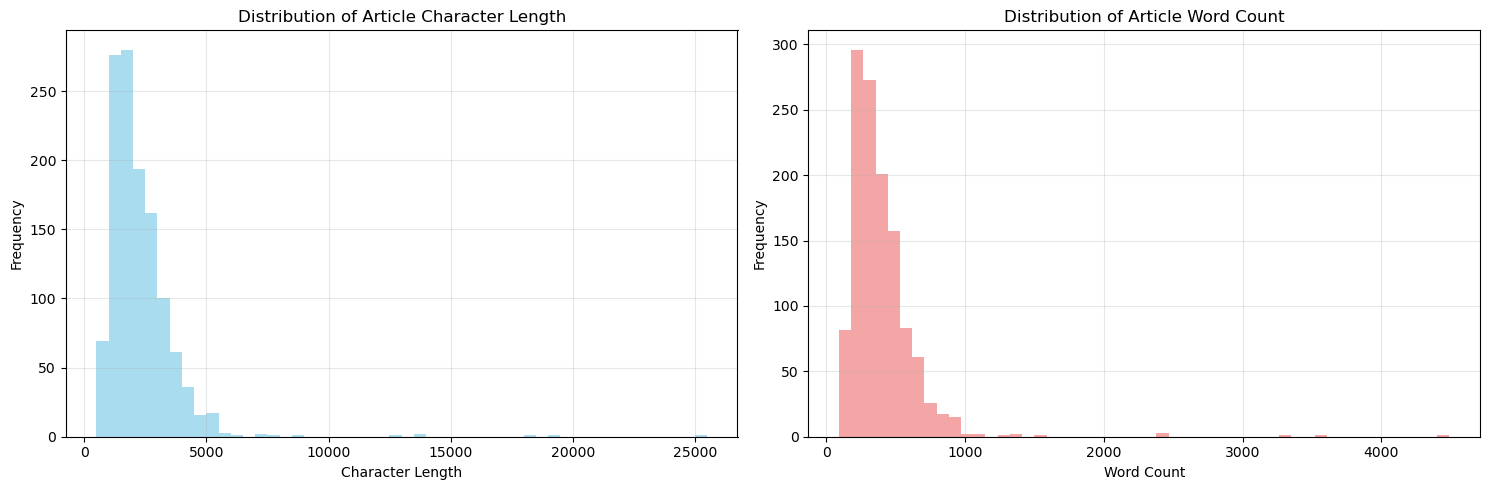

In [5]:
news_df['text_length'] = news_df['text'].str.len()
news_df['word_count'] = news_df['text'].str.split().str.len()

print("=== TEXT LENGTH STATISTICS ===")
print(f"Average text length: {news_df['text_length'].mean():.0f} characters")
print(f"Average word count: {news_df['word_count'].mean():.0f} words")
print(news_df['text_length'].describe())

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].hist(news_df['text_length'], bins=50, alpha=0.7, color='skyblue')
axes[0].set_xlabel('Character Length')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Article Character Length')
axes[0].grid(True, alpha=0.3)

axes[1].hist(news_df['word_count'], bins=50, alpha=0.7, color='lightcoral')
axes[1].set_xlabel('Word Count')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Article Word Count')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

=== CATEGORY DISTRIBUTION ===
label_text
business         286
sport            275
politics         242
tech             212
entertainment    210
Name: count, dtype: int64


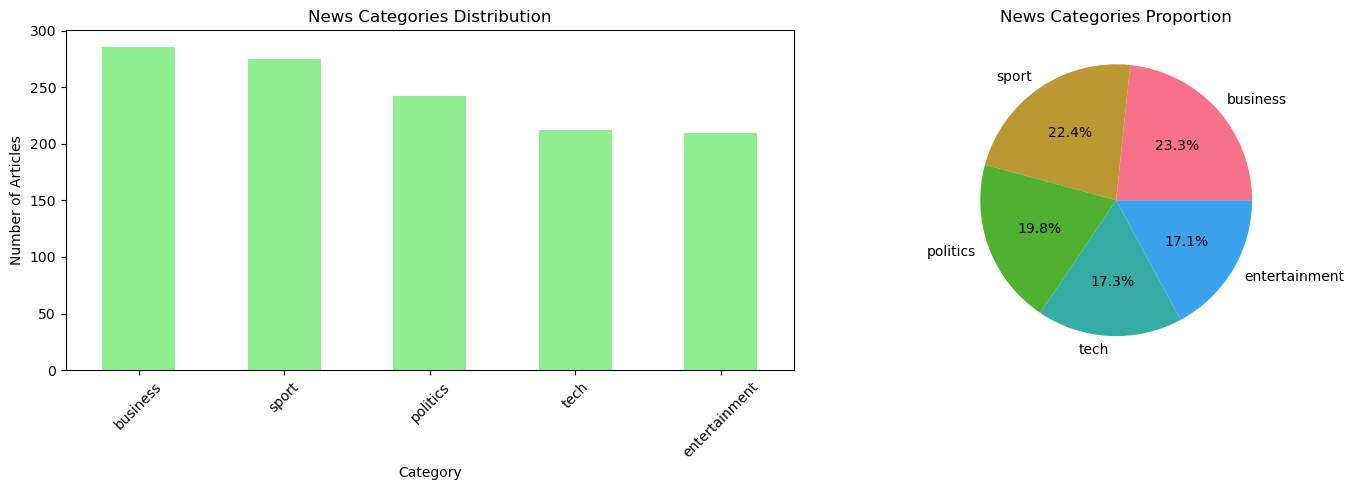


=== AVERAGE TEXT LENGTH BY CATEGORY ===
label_text
tech             3026.471698
politics         2728.268595
business         2028.391608
entertainment    1915.866667
sport            1889.650909
Name: text_length, dtype: float64


In [6]:
if 'label_text' in news_df.columns:
    print("=== CATEGORY DISTRIBUTION ===")
    category_counts = news_df['label_text'].value_counts()
    print(category_counts)
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    category_counts.plot(kind='bar', ax=axes[0], color='lightgreen')
    axes[0].set_title('News Categories Distribution')
    axes[0].set_xlabel('Category')
    axes[0].set_ylabel('Number of Articles')
    axes[0].tick_params(axis='x', rotation=45)
    
    axes[1].pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%')
    axes[1].set_title('News Categories Proportion')
    
    plt.tight_layout()
    plt.show()
    
    print("\n=== AVERAGE TEXT LENGTH BY CATEGORY ===")
    avg_length_by_category = news_df.groupby('label_text')['text_length'].mean().sort_values(ascending=False)
    print(avg_length_by_category)
else:
    print("No category labels found in the dataset")

## 5. Text Preprocessing Functions

In [7]:
class TextPreprocessor:
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))
    
    def clean_text(self, text):
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        text = re.sub(r'\s+', ' ', text)
        return text.strip().lower()
    
    def remove_stopwords_and_lemmatize(self, text):
        tokens = word_tokenize(text)
        filtered_tokens = [
            self.lemmatizer.lemmatize(word) 
            for word in tokens 
            if word not in self.stop_words and len(word) > 2
        ]
        return ' '.join(filtered_tokens)
    
    def preprocess_text(self, text):
        cleaned = self.clean_text(text)
        processed = self.remove_stopwords_and_lemmatize(cleaned)
        return processed

preprocessor = TextPreprocessor()
print("TextPreprocessor initialized successfully")

TextPreprocessor initialized successfully


In [8]:
sample_text = news_df['text'].iloc[0]

print("=== PREPROCESSING EXAMPLE ===")
print(f"Original text:\n{sample_text[:200]}...\n")

cleaned_text = preprocessor.clean_text(sample_text)
print(f"After cleaning:\n{cleaned_text[:200]}...\n")

processed_text = preprocessor.preprocess_text(sample_text)
print(f"After full preprocessing:\n{processed_text[:200]}...")

=== PREPROCESSING EXAMPLE ===
Original text:
wales want rugby league training wales could follow england s lead by training with a rugby league club.  england have already had a three-day session with leeds rhinos  and wales are thought to be in...

After cleaning:
wales want rugby league training wales could follow england s lead by training with a rugby league club england have already had a threeday session with leeds rhinos and wales are thought to be intere...

After full preprocessing:
wale want rugby league training wale could follow england lead training rugby league club england already threeday session leeds rhino wale thought interested similar clinic rival helen saint coach ia...
After full preprocessing:
wale want rugby league training wale could follow england lead training rugby league club england already threeday session leeds rhino wale thought interested similar clinic rival helen saint coach ia...


## 6. Apply Preprocessing to Dataset

In [9]:
print("Applying preprocessing to all articles...")

news_df['text_cleaned'] = news_df['text'].apply(preprocessor.clean_text)
news_df['text_processed'] = news_df['text'].apply(preprocessor.preprocess_text)

news_df['processed_length'] = news_df['text_processed'].str.len()
news_df['processed_word_count'] = news_df['text_processed'].str.split().str.len()

print("✓ Preprocessing completed!")
print(f"Average processed length: {news_df['processed_length'].mean():.0f} characters")
print(f"Average processed word count: {news_df['processed_word_count'].mean():.0f} words")

Applying preprocessing to all articles...
✓ Preprocessing completed!
Average processed length: 1517 characters
Average processed word count: 212 words
✓ Preprocessing completed!
Average processed length: 1517 characters
Average processed word count: 212 words


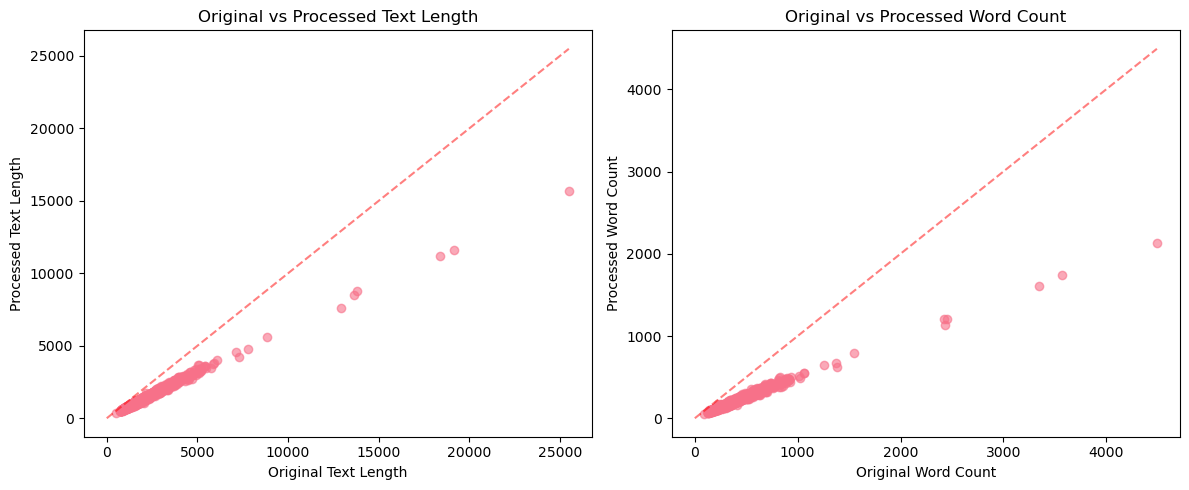

Average character reduction: 33.3%
Average word reduction: 45.7%


In [10]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(news_df['text_length'], news_df['processed_length'], alpha=0.6)
plt.xlabel('Original Text Length')
plt.ylabel('Processed Text Length')
plt.title('Original vs Processed Text Length')
plt.plot([0, news_df['text_length'].max()], [0, news_df['text_length'].max()], 'r--', alpha=0.5)

plt.subplot(1, 2, 2)
plt.scatter(news_df['word_count'], news_df['processed_word_count'], alpha=0.6)
plt.xlabel('Original Word Count')
plt.ylabel('Processed Word Count')
plt.title('Original vs Processed Word Count')
plt.plot([0, news_df['word_count'].max()], [0, news_df['word_count'].max()], 'r--', alpha=0.5)

plt.tight_layout()
plt.show()

reduction_chars = (news_df['text_length'] - news_df['processed_length']) / news_df['text_length'] * 100
reduction_words = (news_df['word_count'] - news_df['processed_word_count']) / news_df['word_count'] * 100

print(f"Average character reduction: {reduction_chars.mean():.1f}%")
print(f"Average word reduction: {reduction_words.mean():.1f}%")

## 7. Vocabulary Analysis

In [11]:
print("=== VOCABULARY ANALYSIS ===")

all_text = ' '.join(news_df['text_processed'].dropna())
words = all_text.split()
word_freq = Counter(words)

print(f"Total words: {len(words)}")
print(f"Unique words: {len(word_freq)}")
print(f"Vocabulary richness: {len(word_freq)/len(words):.3f}")

print(f"\nTop 20 most common words:")
for word, count in word_freq.most_common(20):
    print(f"{word}: {count}")

=== VOCABULARY ANALYSIS ===
Total words: 259795
Unique words: 20893
Vocabulary richness: 0.080

Top 20 most common words:
said: 3998
year: 1662
would: 1486
also: 1203
people: 1174
new: 1060
one: 1043
could: 900
last: 790
time: 779
say: 729
world: 712
first: 711
government: 705
game: 683
two: 664
make: 627
company: 619
film: 586
service: 553


WordCloud failed: Only supported for TrueType fonts
Creating alternative visualization with bar charts...


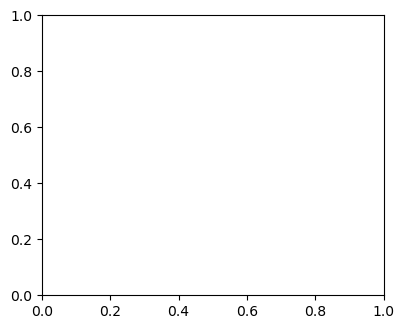

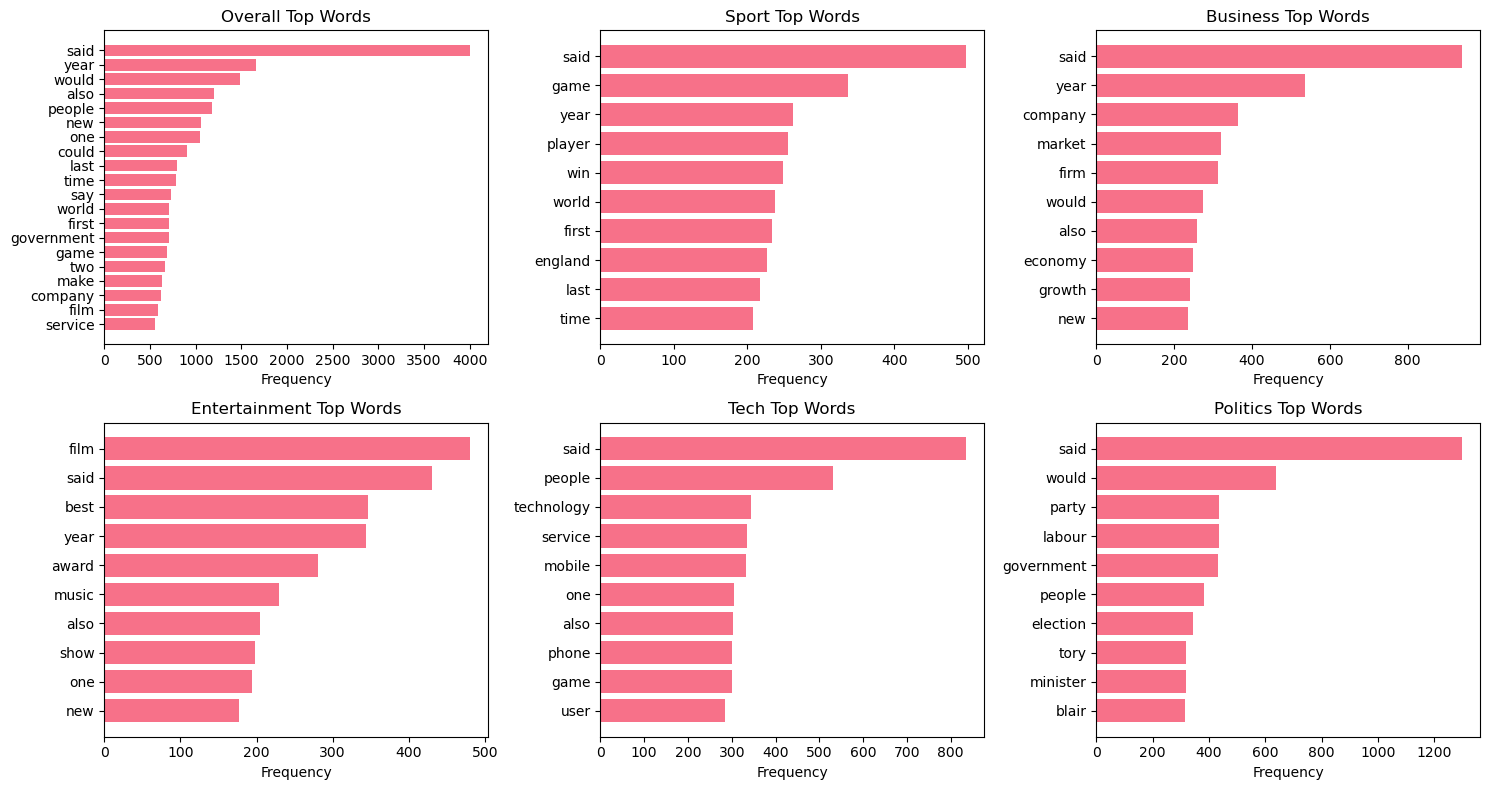

In [12]:
try:
    plt.figure(figsize=(15, 8))
    
    plt.subplot(2, 3, 1)
    wordcloud = WordCloud(
        width=400, 
        height=300, 
        background_color='white',
        font_path='/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf',
        prefer_horizontal=0.9,
        max_words=100
    ).generate(all_text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title('Overall Vocabulary')
    plt.axis('off')
    
    if 'label_text' in news_df.columns:
        categories = news_df['label_text'].unique()[:5]
        
        for i, category in enumerate(categories):
            plt.subplot(2, 3, i + 2)
            
            category_text = ' '.join(
                news_df[news_df['label_text'] == category]['text_processed'].dropna()
            )
            
            if category_text.strip():
                wordcloud = WordCloud(
                    width=400, 
                    height=300, 
                    background_color='white',
                    font_path='/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf',
                    prefer_horizontal=0.9,
                    max_words=100
                ).generate(category_text)
                plt.imshow(wordcloud, interpolation='bilinear')
            
            plt.title(f'{category.title()} Category')
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"WordCloud failed: {e}")
    print("Creating alternative visualization with bar charts...")
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    axes = axes.flatten()
    
    # Overall top words
    top_words = dict(word_freq.most_common(20))
    axes[0].barh(list(top_words.keys())[::-1], list(top_words.values())[::-1])
    axes[0].set_title('Overall Top Words')
    axes[0].set_xlabel('Frequency')
    
    if 'label_text' in news_df.columns:
        categories = news_df['label_text'].unique()[:5]
        
        for i, category in enumerate(categories):
            if i + 1 < len(axes):
                category_text = ' '.join(
                    news_df[news_df['label_text'] == category]['text_processed'].dropna()
                )
                
                if category_text.strip():
                    category_words = Counter(category_text.split())
                    top_cat_words = dict(category_words.most_common(10))
                    
                    if top_cat_words:
                        axes[i + 1].barh(list(top_cat_words.keys())[::-1], 
                                       list(top_cat_words.values())[::-1])
                    axes[i + 1].set_title(f'{category.title()} Top Words')
                    axes[i + 1].set_xlabel('Frequency')
    
    for i in range(len(categories) + 1, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

## 8. Feature Extraction

In [13]:
news_df_clean = news_df[news_df['text_processed'].str.len() > 0].copy()
print(f"Articles after removing empty processed texts: {len(news_df_clean)}")

print("\n=== TF-IDF FEATURE EXTRACTION ===")

tfidf_configs = {
    'basic': {
        'max_features': 1000,
        'min_df': 2,
        'max_df': 0.8,
        'ngram_range': (1, 1)
    },
    'bigrams': {
        'max_features': 1500,
        'min_df': 2,
        'max_df': 0.8,
        'ngram_range': (1, 2)
    },
    'trigrams': {
        'max_features': 2000,
        'min_df': 2,
        'max_df': 0.8,
        'ngram_range': (1, 3)
    }
}

tfidf_matrices = {}
tfidf_vectorizers = {}

for config_name, config in tfidf_configs.items():
    print(f"\nCreating TF-IDF matrix for {config_name} configuration...")
    
    vectorizer = TfidfVectorizer(**config)
    tfidf_matrix = vectorizer.fit_transform(news_df_clean['text_processed'])
    
    tfidf_matrices[config_name] = tfidf_matrix
    tfidf_vectorizers[config_name] = vectorizer
    
    print(f"✓ {config_name}: Matrix shape: {tfidf_matrix.shape}")
    print(f"  Features: {len(vectorizer.get_feature_names_out())}")
    print(f"  Sparsity: {(1 - tfidf_matrix.nnz / (tfidf_matrix.shape[0] * tfidf_matrix.shape[1])):.3f}")

Articles after removing empty processed texts: 1225

=== TF-IDF FEATURE EXTRACTION ===

Creating TF-IDF matrix for basic configuration...
✓ basic: Matrix shape: (1225, 1000)
  Features: 1000
  Sparsity: 0.923

Creating TF-IDF matrix for bigrams configuration...
✓ bigrams: Matrix shape: (1225, 1500)
  Features: 1500
  Sparsity: 0.940

Creating TF-IDF matrix for trigrams configuration...
✓ bigrams: Matrix shape: (1225, 1500)
  Features: 1500
  Sparsity: 0.940

Creating TF-IDF matrix for trigrams configuration...
✓ trigrams: Matrix shape: (1225, 2000)
  Features: 2000
  Sparsity: 0.950
✓ trigrams: Matrix shape: (1225, 2000)
  Features: 2000
  Sparsity: 0.950


In [14]:
print("=== TOP TF-IDF FEATURES ===")

vectorizer = tfidf_vectorizers['bigrams']
tfidf_matrix = tfidf_matrices['bigrams']

feature_names = vectorizer.get_feature_names_out()
mean_scores = np.array(tfidf_matrix.mean(axis=0)).flatten()

top_indices = mean_scores.argsort()[-20:][::-1]
top_features = [(feature_names[i], mean_scores[i]) for i in top_indices]

print("Top 20 TF-IDF features (by mean score):")
for i, (feature, score) in enumerate(top_features):
    print(f"{i+1:2d}. {feature}: {score:.4f}")

=== TOP TF-IDF FEATURES ===
Top 20 TF-IDF features (by mean score):
 1. year: 0.0322
 2. would: 0.0284
 3. film: 0.0253
 4. people: 0.0244
 5. new: 0.0234
 6. game: 0.0229
 7. also: 0.0229
 8. one: 0.0218
 9. last: 0.0201
10. world: 0.0201
11. could: 0.0198
12. company: 0.0197
13. government: 0.0195
14. first: 0.0195
15. time: 0.0185
16. firm: 0.0178
17. two: 0.0176
18. say: 0.0176
19. best: 0.0168
20. labour: 0.0163


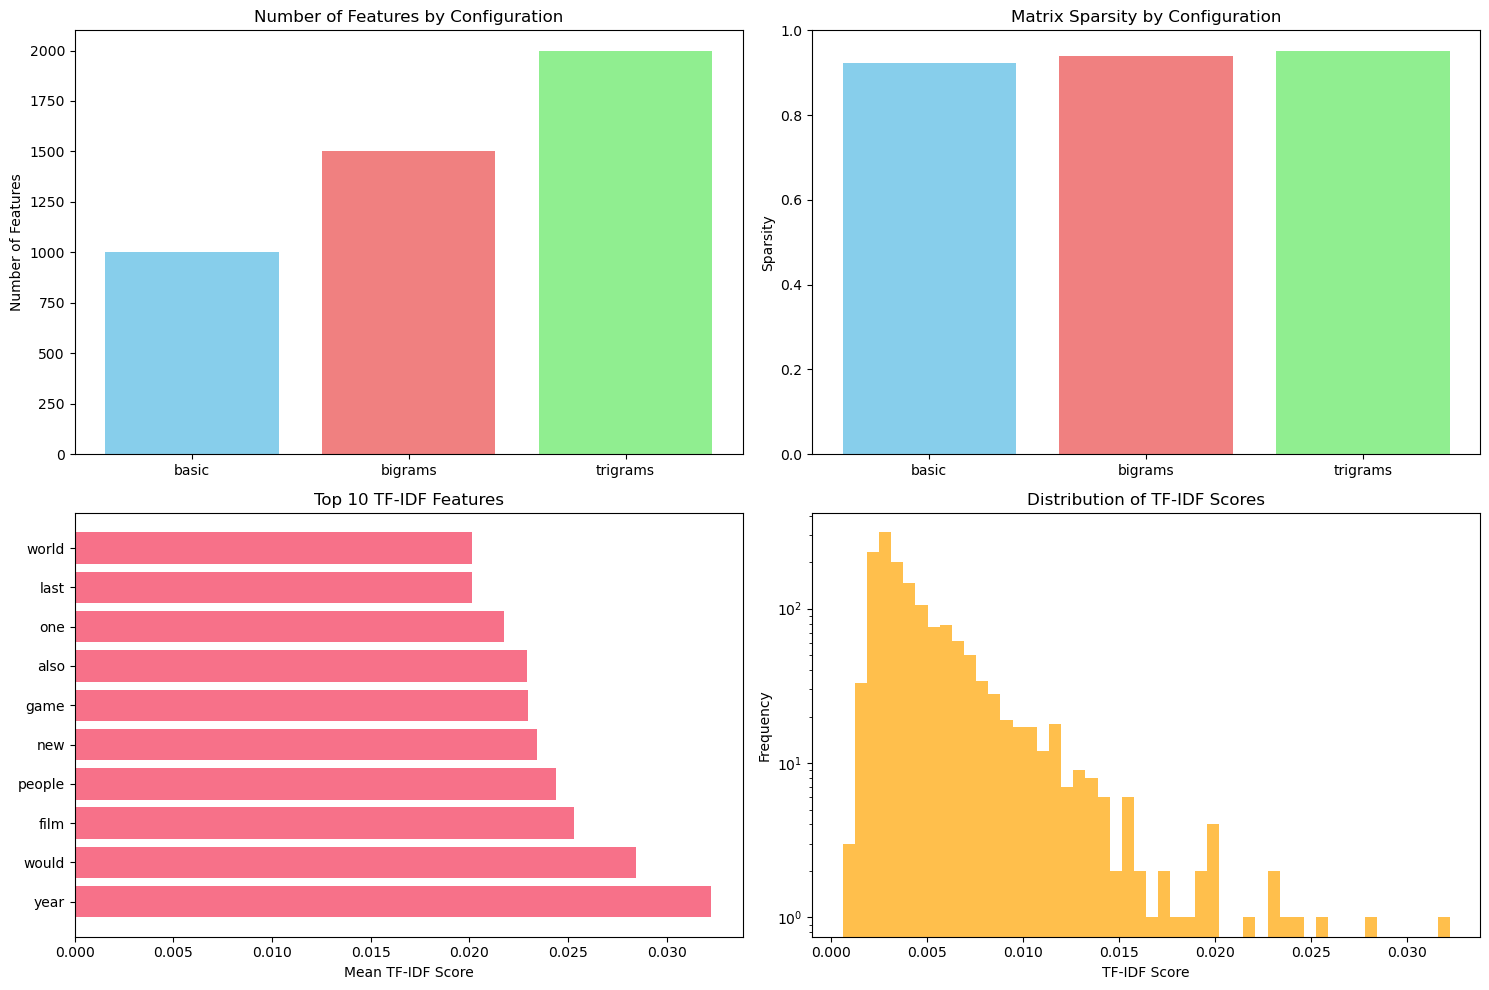

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

feature_counts = [len(vectorizer.get_feature_names_out()) for vectorizer in tfidf_vectorizers.values()]
config_names = list(tfidf_configs.keys())

axes[0, 0].bar(config_names, feature_counts, color=['skyblue', 'lightcoral', 'lightgreen'])
axes[0, 0].set_title('Number of Features by Configuration')
axes[0, 0].set_ylabel('Number of Features')

sparsities = []
for matrix in tfidf_matrices.values():
    sparsity = 1 - matrix.nnz / (matrix.shape[0] * matrix.shape[1])
    sparsities.append(sparsity)

axes[0, 1].bar(config_names, sparsities, color=['skyblue', 'lightcoral', 'lightgreen'])
axes[0, 1].set_title('Matrix Sparsity by Configuration')
axes[0, 1].set_ylabel('Sparsity')
axes[0, 1].set_ylim([0, 1])

top_10_features = [feature for feature, score in top_features[:10]]
top_10_scores = [score for feature, score in top_features[:10]]

axes[1, 0].barh(range(len(top_10_features)), top_10_scores)
axes[1, 0].set_yticks(range(len(top_10_features)))
axes[1, 0].set_yticklabels(top_10_features)
axes[1, 0].set_title('Top 10 TF-IDF Features')
axes[1, 0].set_xlabel('Mean TF-IDF Score')

all_scores = mean_scores[mean_scores > 0]
axes[1, 1].hist(all_scores, bins=50, alpha=0.7, color='orange')
axes[1, 1].set_title('Distribution of TF-IDF Scores')
axes[1, 1].set_xlabel('TF-IDF Score')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_yscale('log')

plt.tight_layout()
plt.show()

## 9. Save Processed Data

In [16]:
news_df_clean.to_csv('processed_news_data.csv', index=False)
print("✓ Saved processed news data to 'processed_news_data.csv'")

import pickle

tfidf_data = {
    'matrices': tfidf_matrices,
    'vectorizers': tfidf_vectorizers,
    'feature_names': {name: vec.get_feature_names_out() for name, vec in tfidf_vectorizers.items()},
    'configurations': tfidf_configs
}

with open('tfidf_features.pkl', 'wb') as f:
    pickle.dump(tfidf_data, f)

print("✓ Saved TF-IDF features to 'tfidf_features.pkl'")

summary_stats = {
    'dataset_info': {
        'total_articles': len(news_df_clean),
        'categories': news_df_clean['label_text'].value_counts().to_dict() if 'label_text' in news_df_clean.columns else None,
        'avg_original_length': news_df_clean['text_length'].mean(),
        'avg_processed_length': news_df_clean['processed_length'].mean(),
        'avg_original_words': news_df_clean['word_count'].mean(),
        'avg_processed_words': news_df_clean['processed_word_count'].mean()
    },
    'vocabulary_info': {
        'total_words': len(words),
        'unique_words': len(word_freq),
        'vocabulary_richness': len(word_freq)/len(words)
    },
    'tfidf_info': {
        config_name: {
            'matrix_shape': tfidf_matrices[config_name].shape,
            'num_features': len(tfidf_vectorizers[config_name].get_feature_names_out()),
            'sparsity': 1 - tfidf_matrices[config_name].nnz / (tfidf_matrices[config_name].shape[0] * tfidf_matrices[config_name].shape[1])
        } for config_name in tfidf_configs.keys()
    }
}

with open('preprocessing_summary.pkl', 'wb') as f:
    pickle.dump(summary_stats, f)

print("✓ Saved preprocessing summary to 'preprocessing_summary.pkl'")

✓ Saved processed news data to 'processed_news_data.csv'
✓ Saved TF-IDF features to 'tfidf_features.pkl'
✓ Saved preprocessing summary to 'preprocessing_summary.pkl'


## 10. Data Summary and Next Steps

In [17]:
print("=== DATA PREPROCESSING COMPLETE ===")
print(f"\n📊 Dataset Summary:")
print(f"   • Total articles processed: {len(news_df_clean)}")
if 'label_text' in news_df_clean.columns:
    print(f"   • Categories: {news_df_clean['label_text'].nunique()}")
    print(f"   • Category distribution: {dict(news_df_clean['label_text'].value_counts())}")

# Calculate reduction statistics if variables exist
if 'processed_length' in news_df_clean.columns and 'text_length' in news_df_clean.columns:
    reduction_chars = (news_df_clean['text_length'] - news_df_clean['processed_length']) / news_df_clean['text_length'] * 100
    reduction_words = (news_df_clean['word_count'] - news_df_clean['processed_word_count']) / news_df_clean['word_count'] * 100
    print(f"   • Average text reduction: {reduction_chars.mean():.1f}% (characters), {reduction_words.mean():.1f}% (words)")

print(f"\n📝 Text Processing:")
if 'word_freq' in locals():
    print(f"   • Vocabulary size: {len(word_freq):,} unique words")
if 'processed_word_count' in news_df_clean.columns:
    print(f"   • Average article length: {news_df_clean['processed_word_count'].mean():.0f} words")

print(f"\n🔢 Feature Extraction:")
if 'tfidf_matrices' in locals():
    for config_name, matrix in tfidf_matrices.items():
        print(f"   • {config_name.title()}: {matrix.shape[1]} features, {matrix.shape[0]} documents")

print(f"\nFiles Created:")
print(f"   - processed_news_data.csv - Cleaned and processed text data")
print(f"   - tfidf_features.pkl - TF-IDF matrices and vectorizers")
print(f"   - preprocessing_summary.pkl - Summary statistics")

print(f"\nReady for Model Training!")
print(f"   The data is now ready for the training and comparison notebook.")
print(f"   You can proceed with unsupervised clustering algorithms like:")
print(f"   - K-Means clustering")
print(f"   - Hierarchical clustering")
print(f"   - DBSCAN")
print(f"   - Topic modeling (LDA, NMF)")

=== DATA PREPROCESSING COMPLETE ===

📊 Dataset Summary:
   • Total articles processed: 1225
   • Categories: 5
   • Category distribution: {'business': 286, 'sport': 275, 'politics': 242, 'tech': 212, 'entertainment': 210}
   • Average text reduction: 33.3% (characters), 45.7% (words)

📝 Text Processing:
   • Vocabulary size: 20,893 unique words
   • Average article length: 212 words

🔢 Feature Extraction:
   • Basic: 1000 features, 1225 documents
   • Bigrams: 1500 features, 1225 documents
   • Trigrams: 2000 features, 1225 documents

Files Created:
   - processed_news_data.csv - Cleaned and processed text data
   - tfidf_features.pkl - TF-IDF matrices and vectorizers
   - preprocessing_summary.pkl - Summary statistics

Ready for Model Training!
   The data is now ready for the training and comparison notebook.
   You can proceed with unsupervised clustering algorithms like:
   - K-Means clustering
   - Hierarchical clustering
   - DBSCAN
   - Topic modeling (LDA, NMF)
